# PAF Calculations with the Interactive Sim 

The integration approach to PAF calculations is attempted in PAF calculations. This worked for SBP to HF only as that is a categorical risk. For the BMI continuous risk, the integration did not work as expected. Therefore, we are trying a new approach via the interactive sim. 

The PAFs I need are: 
- BMI to HF 
- BMI to IHD 
- BMI to Stroke

In [1]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)
import seaborn as sns

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [3]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 10_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-01-17 07:47:33.789 | DEBUG    | vivarium.framework.values:register_value_modifier:392 - Registering metrics.1.population_manager.metrics as modifier to metrics
2023-01-17 07:47:33.906 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:66 - Running simulation from artifact located at /ihme/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-01-17 07:47:33.908 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:67 - Artifact base filter terms are ['draw == 0'].
2023-01-17 07:47:33.912 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:68 - Artifact additional filter terms are None.
2023-01-17 07:47:34.298 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline cause_specific_mortality_rate
2023-01-17 07:47:34.298 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline mortality_rate
2023-01-17 07:47:34.657 | DEBUG    | vivarium.framework.values:_regis

In [4]:
pop0 = sim.get_population()
pop0.head()

,tracked,age,alive,exit_time,location,entrance_time,sex,years_of_life_lost,cause_of_death,years_lived_with_disability,...,sbp_multiplier,ldlc_medication,outreach,sbp_medication_adherence,polypill,ldlc_multiplier,sbp_medication,ldlc_medication_adherence,scheduled_date,visit_type
0,True,47.388882,alive,NaT,Alabama,2020-12-04,Female,0.0,not_dead,0.0,...,1.0,no_treatment,cat2,cat3,cat2,1.000,no_treatment,cat3,NaT,none
1,True,41.564194,alive,NaT,Alabama,2020-12-04,Male,0.0,not_dead,0.0,...,1.0,no_treatment,cat2,cat3,cat2,1.000,no_treatment,cat3,NaT,none
2,True,53.155826,alive,NaT,Alabama,2020-12-04,Female,0.0,not_dead,0.0,...,1.0,medium_intensity,cat2,cat1,cat2,1.362,one_drug_half_dose_efficacy,cat3,NaT,none
3,True,30.457692,alive,NaT,Alabama,2020-12-04,Male,0.0,not_dead,0.0,...,1.0,no_treatment,cat2,cat3,cat2,1.000,no_treatment,cat1,NaT,none
4,True,19.554806,alive,NaT,Alabama,2020-12-04,Female,0.0,not_dead,0.0,...,1.0,no_treatment,cat2,cat3,cat2,1.000,no_treatment,cat1,NaT,none


In [5]:
pop1 = pop0[['sex','alive','age']]

In [6]:
#pop0.columns

In [7]:
#sim.list_values()

In [91]:
data1 = pd.concat([pop1,
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('bmi_propensity'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('bmi_exposure'),
                   sim.get_value('high_ldl_cholesterol.propensity')(pop0.index).rename('ldl_propensity'),
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('ldl_exposure'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('sbp_propensity'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('sbp_exposure'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate')(pop0.index).rename('mi_incidence'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate.paf')(pop0.index).rename('mi_incidence_paf'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate')(pop0.index).rename('stroke_incidence'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate.paf')(pop0.index).rename('stroke_incidence_paf'),
                  ], axis=1)
data1.head()

,sex,alive,age,bmi_propensity,bmi_exposure,ldl_propensity,ldl_exposure,sbp_propensity,sbp_exposure,mi_incidence,mi_incidence_paf,stroke_incidence,stroke_incidence_paf
0,Female,alive,47.388882,0.208828,23.564850,0.362468,2.672922,0.650952,126.711324,0.000010,0.967287,0.000008,0.959927
1,Male,alive,41.564194,0.358604,25.661107,0.695510,3.377397,0.625507,135.497307,0.000028,0.983091,0.000008,0.969345
2,Female,alive,53.155826,0.531571,34.110372,0.155857,1.864838,0.165289,112.215005,0.000020,0.941682,0.000019,0.947248
3,Male,alive,30.457692,0.388049,26.473747,0.821628,4.959918,0.162353,114.705760,0.000012,0.990950,0.000001,0.981074
4,Female,alive,19.554806,0.672873,5.000000,0.658736,0.000000,0.479221,50.000000,0.000008,0.000000,0.000006,0.000000


In [92]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]

In [93]:
age_group = pd.cut(data1.age, bins=[25,30,35,40,45,50,55,60,65,70,75,80,85,90,125],labels=['25_to_30','30_to_35','35_to_40','40_to_45','45_to_50','50_to_55','55_to_60','60_to_65','65_to_70','70_to_75','75_to_80','80_to_85','85_to_90','90_to_125'])
data1.insert(13, 'age_group', age_group)

In [94]:
data1.age_group.unique()

['45_to_50', '40_to_45', '50_to_55', '30_to_35', '35_to_40', ..., '85_to_90', '25_to_30', '70_to_75', '90_to_125', '80_to_85']
Length: 14
Categories (14, object): ['25_to_30' < '30_to_35' < '35_to_40' < '40_to_45' ... '75_to_80' < '80_to_85' < '85_to_90' < '90_to_125']

In [95]:
sex_list = (['Female','Male'])

In [96]:
data1_new = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data1.age_group.unique())]: 
        data_current = data1.loc[(data1.sex == sex) & (data1.age_group == age)]
        data_current['bmi_rank'] = data_current.bmi_exposure.rank()
        data_current['ldl_rank'] = data_current.ldl_exposure.rank()
        data_current['sbp_rank'] = data_current.sbp_exposure.rank()
        data1_new = data1_new.append(data_current)
data1_new

/tmp/ipykernel_2697299/1185586062.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_current['bmi_rank'] = data_current.bmi_exposure.rank()
/tmp/ipykernel_2697299/1185586062.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_current['ldl_rank'] = data_current.ldl_exposure.rank()
/tmp/ipykernel_2697299/1185586062.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

,sex,alive,age,bmi_propensity,bmi_exposure,ldl_propensity,ldl_exposure,sbp_propensity,sbp_exposure,mi_incidence,mi_incidence_paf,stroke_incidence,stroke_incidence_paf,age_group,bmi_rank,ldl_rank,sbp_rank
0,Female,alive,47.388882,0.208828,23.564850,0.362468,2.672922,0.650952,126.711324,0.000010,0.967287,0.000008,0.959927,45_to_50,82.0,142.0,248.0
18,Female,alive,47.593991,0.989864,49.302438,0.346926,2.597841,0.074565,104.827776,0.000058,0.967287,0.000093,0.959927,45_to_50,360.0,129.0,20.0
71,Female,alive,46.463245,0.161256,21.044691,0.328825,2.642607,0.083860,103.161416,0.000005,0.967287,0.000004,0.959927,45_to_50,42.0,137.0,15.0
76,Female,alive,49.802613,0.139220,22.158965,0.075035,1.729700,0.174775,110.805907,0.000003,0.967287,0.000003,0.959927,45_to_50,59.0,21.0,52.0
84,Female,alive,49.964748,0.463160,32.736415,0.389316,2.656644,0.601588,123.820624,0.000021,0.967287,0.000022,0.959927,45_to_50,219.0,139.0,211.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8989,Male,alive,81.848497,0.640466,29.184111,0.191945,2.091435,0.431516,134.081197,0.001172,0.721583,0.000368,0.587276,80_to_85,51.0,18.0,44.0
9608,Male,alive,84.973974,0.424359,25.336148,0.219816,1.853907,0.326979,127.049571,0.000816,0.721583,0.000291,0.587276,80_to_85,25.0,9.0,23.0
9772,Male,alive,82.620335,0.922729,33.001578,0.935793,4.061447,0.355575,127.738665,0.001938,0.721583,0.000509,0.587276,80_to_85,62.0,71.0,27.0
9982,Male,alive,83.277997,0.307639,23.991826,0.149850,1.869206,0.637676,135.093925,0.000916,0.721583,0.000324,0.587276,80_to_85,20.0,12.0,46.0


(array([1046.,  964.,  875.,  857.,  803.,  763.,  667.,  665.,  562.,
         246.]),
 array([  1.  ,  38.85,  76.7 , 114.55, 152.4 , 190.25, 228.1 , 265.95,
        303.8 , 341.65, 379.5 ]),
 <BarContainer object of 10 artists>)

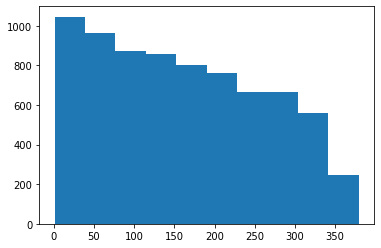

In [97]:
plt.hist(data1_new.bmi_rank)

Given that the ranks max out around 350 and drop off for higher numbers (less age/sex groups have more people in them) I am assuming the above loop worked as intended. 

In [99]:
correlation = pd.read_csv('/ihme/homes/lutzes/correlation.csv')
correlation = correlation.drop('Unnamed: 0',axis=1)
old_age = {'age_start': 90, 'age_end': 125, 'sbp_ldl': 0.124353,'sbp_ldl_pval':1.754506e-104,'sbp_bmi':0.005323,'sbp_bmi_pval':9.405201e-01,'ldl_bmi':0.111832,'ldl_bmi_pval':3.384224e-86,'sbp_fpg':0.338096,'sbp_fpg_pval':0,'ldl_fpg':0,'ldl_fpg_pval':'NaN','bmi_fpg':0.294275,'bmi_fpg_pval':0}
correlation = correlation.append(old_age, ignore_index = True)
#correlation

/tmp/ipykernel_2697299/3274002491.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlation = correlation.append(old_age, ignore_index = True)


In [100]:
data_all = pd.DataFrame()
#N = 1000 #can change to be the total population size needed 
for i in range(0,len(correlation)):
    age_start = correlation.iloc[i][0]
    age_end = correlation.iloc[i][1]
    sbp_ldl = correlation.iloc[i][2]
    sbp_bmi = correlation.iloc[i][4]
    bmi_ldl = correlation.iloc[i][6]
    sbp_fpg = correlation.iloc[i][8]
    ldl_fpg = correlation.iloc[i][10]
    bmi_fpg = correlation.iloc[i][12]
    N = len(data1.loc[(data1.age > age_start) & (data1.age < age_end)])
    probit_propensity = np.random.multivariate_normal([0,0,0,0], [[1, sbp_ldl, sbp_bmi, sbp_fpg],
                                                         [sbp_ldl, 1, bmi_ldl, ldl_fpg],
                                                         [sbp_bmi, bmi_ldl, 1, bmi_fpg],
                                                             [sbp_fpg, ldl_fpg, bmi_fpg, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)
    data = pd.DataFrame(data = propensity, 
                       columns = ['SBP','LDL','BMI','FPG'])
    data['age_start'] = age_start
    data['age_end'] = age_end
    data_all = data_all.append(data)
data_all = data_all.reset_index()

/tmp/ipykernel_2697299/606510581.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_all = data_all.append(data)
/tmp/ipykernel_2697299/606510581.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_all = data_all.append(data)
/tmp/ipykernel_2697299/606510581.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_all = data_all.append(data)
/tmp/ipykernel_2697299/606510581.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_all = data_all.append(data)
/tmp/ipykernel_2697299/606510581.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

In [101]:
#Checking that this worked as expected and it does! 
len(data_all), len(data1_new)

(7448, 7448)

In [102]:
data_new = data1_new[['age','sex']]
data_new = data_new.sort_values(by=['age']).reset_index()
data_new = data_new.drop('index',axis=1)
#data_new.head()

In [103]:
data_new = pd.concat([data_new, data_all], axis=1)

In [104]:
data_new['age_group'] = [f'{int(i)}_to_{int(j)}' for (i,j) in zip(data_new.age_start,data_new.age_end)]
data_new.head()

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group
0,25.006635,Female,0,0.278914,0.667145,0.267914,0.582074,25,30,25_to_30
1,25.014514,Male,1,0.904582,0.745164,0.552936,0.828427,25,30,25_to_30
2,25.018104,Male,2,0.461336,0.573663,0.517739,0.520679,25,30,25_to_30
3,25.021147,Male,3,0.828268,0.049693,0.098870,0.759509,25,30,25_to_30
4,25.038105,Male,4,0.240215,0.251343,0.153167,0.547122,25,30,25_to_30


In [105]:
#Just wanted to check that matching in this way worked as I expected and it seems that it did! 
count=0
for i in range(7448):
    if [(data_new.age.iloc[i] > data_new.age_start.iloc[i]) & (data_new.age.iloc[i] > data_new.age_end.iloc[i])]:
        count = count + 1
print(count)

7448


In [106]:
data_final = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current = data_new.loc[(data_new.sex == sex) & (data_new.age_group == age)]
        data_current['bmi_rank'] = data_current.BMI.rank()
        data_current['ldl_rank'] = data_current.LDL.rank()
        data_current['sbp_rank'] = data_current.SBP.rank()
        data_final = data_final.append(data_current)
data_final

/tmp/ipykernel_2697299/139953854.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_current['bmi_rank'] = data_current.BMI.rank()
/tmp/ipykernel_2697299/139953854.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_current['ldl_rank'] = data_current.LDL.rank()
/tmp/ipykernel_2697299/139953854.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group,bmi_rank,ldl_rank,sbp_rank
0,25.006635,Female,0,0.278914,0.667145,0.267914,0.582074,25,30,25_to_30,105.0,240.0,116.0
6,25.067368,Female,6,0.352260,0.636619,0.273046,0.419483,25,30,25_to_30,107.0,227.0,149.0
7,25.076838,Female,7,0.032142,0.417990,0.076866,0.122694,25,30,25_to_30,33.0,146.0,19.0
8,25.083359,Female,8,0.292945,0.339558,0.015819,0.103415,25,30,25_to_30,9.0,123.0,119.0
11,25.100092,Female,11,0.176201,0.337303,0.094527,0.254126,25,30,25_to_30,36.0,121.0,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,97.466628,Male,52,0.565171,0.451879,0.486853,0.578184,90,125,90_to_125,5.0,5.0,15.0
7437,97.789606,Male,53,0.256242,0.897668,0.980255,0.375732,90,125,90_to_125,19.0,17.0,11.0
7441,100.593125,Male,57,0.193893,0.492160,0.621772,0.152061,90,125,90_to_125,10.0,8.0,7.0
7444,104.731512,Male,60,0.078023,0.208221,0.440691,0.014473,90,125,90_to_125,4.0,2.0,2.0


In [116]:
data_final_all = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current_1 = data_final.loc[(data_final.sex == sex) & (data_final.age_group == age)]
        data_current_2 = data1_new.loc[(data1_new.sex == sex) & (data1_new.age_group == age)]
        data_current_1 = data_current_1.sort_values(by=['bmi_rank']).reset_index()
        data_current_2 = data_current_2.sort_values(by=['bmi_rank']).reset_index() 
        data_current_all = pd.concat([data_current_1, data_current_2['bmi_exposure']], axis=1)
        data_final_all = data_final_all.append(data_current_all)

/tmp/ipykernel_2697299/2380677972.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final_all = data_final_all.append(data_current_all)
/tmp/ipykernel_2697299/2380677972.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final_all = data_final_all.append(data_current_all)
/tmp/ipykernel_2697299/2380677972.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final_all = data_final_all.append(data_current_all)
/tmp/ipykernel_2697299/2380677972.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final_all = data_final_all.append(data_current_all)
/tmp/ipykernel_2697299/2380677972.py:9: FutureWarning: The frame.append 

In [122]:
data_final_all = data_final_all.drop(['level_0'],axis=1)
data_final_all

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group,bmi_rank,ldl_rank,sbp_rank,bmi_exposure
0,25.881932,Female,114,0.389013,0.405947,0.002953,0.025982,25,30,25_to_30,1.0,143.0,163.0,5.000000
1,26.083366,Female,149,0.650084,0.975798,0.009029,0.692693,25,30,25_to_30,2.0,361.0,251.0,5.000000
2,27.208668,Female,330,0.035731,0.862606,0.010165,0.197767,25,30,25_to_30,3.0,311.0,20.0,9.429411
3,27.406677,Female,360,0.861882,0.451691,0.010610,0.120538,25,30,25_to_30,4.0,159.0,322.0,12.151497
4,28.083488,Female,461,0.805842,0.795902,0.013639,0.357593,25,30,25_to_30,5.0,293.0,298.0,13.137987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,94.124386,Male,39,0.391395,0.169009,0.924373,0.570494,90,125,90_to_125,16.0,1.0,13.0,31.024761
16,90.863212,Male,6,0.218551,0.923684,0.937925,0.926486,90,125,90_to_125,17.0,18.0,9.0,32.113122
17,94.552362,Male,44,0.640229,0.968175,0.979323,0.538768,90,125,90_to_125,18.0,20.0,16.0,32.384994
18,97.789606,Male,53,0.256242,0.897668,0.980255,0.375732,90,125,90_to_125,19.0,17.0,11.0,34.015081


In [123]:
data_final_all_2 = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current_1 = data_final_all.loc[(data_final_all.sex == sex) & (data_final_all.age_group == age)]
        data_current_2 = data1_new.loc[(data1_new.sex == sex) & (data1_new.age_group == age)]
        data_current_1 = data_current_1.sort_values(by=['ldl_rank']).reset_index()
        data_current_2 = data_current_2.sort_values(by=['ldl_rank']).reset_index() 
        data_current_all = pd.concat([data_current_1, data_current_2['ldl_exposure']], axis=1)
        data_final_all_2 = data_final_all_2.append(data_current_all)

/tmp/ipykernel_2697299/853921741.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final_all_2 = data_final_all_2.append(data_current_all)
/tmp/ipykernel_2697299/853921741.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final_all_2 = data_final_all_2.append(data_current_all)
/tmp/ipykernel_2697299/853921741.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final_all_2 = data_final_all_2.append(data_current_all)
/tmp/ipykernel_2697299/853921741.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final_all_2 = data_final_all_2.append(data_current_all)
/tmp/ipykernel_2697299/853921741.py:9: FutureWarning: The fr

In [127]:
data_final_all_2 = data_final_all_2.drop(['level_0'],axis=1)
data_final_all_2

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group,bmi_rank,ldl_rank,sbp_rank,bmi_exposure,ldl_exposure
0,25.903569,Female,117,0.080505,0.006916,0.128466,0.134497,25,30,25_to_30,51.0,1.0,38.0,21.377842,0.984082
1,25.931178,Female,125,0.749222,0.009064,0.623123,0.801347,25,30,25_to_30,249.0,2.0,286.0,33.442890,1.114077
2,29.198300,Female,631,0.398323,0.011082,0.331078,0.538701,25,30,25_to_30,127.0,3.0,166.0,26.710299,1.167365
3,27.731674,Female,404,0.347382,0.011962,0.248525,0.872996,25,30,25_to_30,100.0,4.0,147.0,24.431445,1.247047
4,28.858835,Female,578,0.725617,0.013003,0.864370,0.899840,25,30,25_to_30,336.0,5.0,275.0,44.615923,1.313440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,92.328687,Male,24,0.983230,0.865124,0.543273,0.963309,90,125,90_to_125,9.0,16.0,20.0,24.554090,3.046483
16,97.789606,Male,53,0.256242,0.897668,0.980255,0.375732,90,125,90_to_125,19.0,17.0,11.0,34.015081,3.062387
17,90.863212,Male,6,0.218551,0.923684,0.937925,0.926486,90,125,90_to_125,17.0,18.0,9.0,32.113122,3.110143
18,93.963017,Male,37,0.909989,0.926104,0.752066,0.722532,90,125,90_to_125,12.0,19.0,18.0,26.656050,3.205984


In [128]:
data_final_all_3 = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current_1 = data_final_all_2.loc[(data_final_all_2.sex == sex) & (data_final_all_2.age_group == age)]
        data_current_2 = data1_new.loc[(data1_new.sex == sex) & (data1_new.age_group == age)]
        data_current_1 = data_current_1.sort_values(by=['sbp_rank']).reset_index()
        data_current_2 = data_current_2.sort_values(by=['sbp_rank']).reset_index() 
        data_current_all = pd.concat([data_current_1, data_current_2['sbp_exposure']], axis=1)
        data_final_all_3 = data_final_all_3.append(data_current_all)

/tmp/ipykernel_2697299/2093096195.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final_all_3 = data_final_all_3.append(data_current_all)
/tmp/ipykernel_2697299/2093096195.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final_all_3 = data_final_all_3.append(data_current_all)
/tmp/ipykernel_2697299/2093096195.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final_all_3 = data_final_all_3.append(data_current_all)
/tmp/ipykernel_2697299/2093096195.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_final_all_3 = data_final_all_3.append(data_current_all)
/tmp/ipykernel_2697299/2093096195.py:9: FutureWarning: T

In [129]:
data_final_all_3

,level_0,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group,bmi_rank,ldl_rank,sbp_rank,bmi_exposure,ldl_exposure,sbp_exposure
0,306,25.485255,Female,64,0.000247,0.847592,0.035046,0.138342,25,30,25_to_30,15.0,307.0,1.0,16.072964,3.651713,50.000000
1,195,28.171946,Female,474,0.000522,0.567986,0.031286,0.370082,25,30,25_to_30,12.0,196.0,2.0,15.165201,2.885002,82.531206
2,101,28.615898,Female,542,0.004966,0.280544,0.546287,0.034439,25,30,25_to_30,222.0,102.0,3.0,31.684058,2.440712,92.695616
3,127,29.901434,Female,724,0.006276,0.356027,0.683824,0.384962,25,30,25_to_30,271.0,128.0,4.0,35.676213,2.577635,94.414876
4,309,27.220813,Female,332,0.008289,0.862173,0.284526,0.003858,25,30,25_to_30,113.0,310.0,5.0,25.353911,3.684733,94.628620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,19,94.552362,Male,44,0.640229,0.968175,0.979323,0.538768,90,125,90_to_125,18.0,20.0,16.0,32.384994,4.178624,128.455692
16,13,94.446923,Male,43,0.707107,0.695501,0.518699,0.132474,90,125,90_to_125,8.0,14.0,17.0,24.009486,2.776327,129.450341
17,18,93.963017,Male,37,0.909989,0.926104,0.752066,0.722532,90,125,90_to_125,12.0,19.0,18.0,26.656050,3.205984,131.756914
18,12,93.386654,Male,32,0.943069,0.689361,0.756484,0.799899,90,125,90_to_125,13.0,13.0,19.0,29.913453,2.772168,133.389334


RR? 
- Use the appropriate values for RR that are in the sim 
- Use artifact values and correct for the draw being used in the interactive sim 
- Then find the individual RR based on their exposures 
- For each risk to cause as well (e.g., individual RR for BMI to MI) 
- Then joint is for all of them together and use this for joint PAFs 